In [12]:
# 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [13]:
# 2. Load and Prepare the Data
# Load your dataset (update the path accordingly)
file_path = "D:/NOTEBOOK/e-commerce-scrubbed-data-filtered.xlsx"
df = pd.read_excel(file_path, usecols=['created_at', 'category_name_1', 'qty_ordered'])
df['created_at'] = pd.to_datetime(df['created_at'])
df['week'] = df['created_at'].dt.to_period('W').apply(lambda r: r.start_time)


In [14]:
# 3. Aggregate Weekly Orders
weekly = df.groupby(['category_name_1', 'week'])['qty_ordered'].count().reset_index()
pivot = weekly.pivot(index='week', columns='category_name_1', values='qty_ordered').fillna(0)
pivot.index = pd.to_datetime(pivot.index)

In [15]:
# 3A. 
# 1. Log Transform
pivot_log = np.log1p(pivot)

# 2. Handle Outliers
def remove_outliers(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    return df_clean

pivot_clean = remove_outliers(pivot_log, pivot_log.columns)

In [16]:
# 4. Split Data into Training and Testing
train_size = len(pivot_clean) - 6  # Last 6 weeks for testing
train_data = pivot_clean.iloc[:train_size]
test_data = pivot_clean.iloc[train_size:]

In [17]:
# 5. Normalize the Data
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data)
scaled_test = scaler.transform(test_data)  # Use the same scaler as training data

In [18]:
# 6. Create LSTM Sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12
X_train, y_train = create_sequences(scaled_train, sequence_length)
X_test, y_test = create_sequences(scaled_test, sequence_length)

In [19]:
# 7. Define and Train LSTM Model
model = Sequential([
    LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'),
    Dense(3)
])
model.compile(optimizer='adam', loss='mse')
model.fit(
    X_train, 
    y_train, 
    epochs=100,           # More epochs for better learning
    batch_size=8,         # Larger batch size for stability
    verbose=1,            # Show progress
)

Epoch 1/100


d:\NOTEBOOK\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2840
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1611 
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0775 
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0434 
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0467 
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0377 
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0419 
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0312 
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0363 
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0386 
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0301 
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0393 
Epoch 13/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0298 
Epoch 14/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0392 
Epoch 15/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0323 
Ep

In [20]:
# 8. Make Predictions
# For training data
train_predictions = model.predict(X_train)
train_predictions_rescaled = scaler.inverse_transform(train_predictions)
train_actual_rescaled = scaler.inverse_transform(y_train)

# For test data - use the last sequence_length weeks of training data to predict the first test week
last_sequence = scaled_train[-sequence_length:]
test_predictions = []
test_actual = scaled_test

# Make predictions for each test week
for i in range(len(test_data)):
    # Predict next week
    next_pred = model.predict(last_sequence.reshape(1, sequence_length, 3))
    test_predictions.append(next_pred[0])
    
    # Update sequence for next prediction
    last_sequence = np.roll(last_sequence, -1, axis=0)
    last_sequence[-1] = next_pred[0]

test_predictions = np.array(test_predictions)
test_predictions_rescaled = scaler.inverse_transform(test_predictions)
test_actual_rescaled = scaler.inverse_transform(test_actual)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


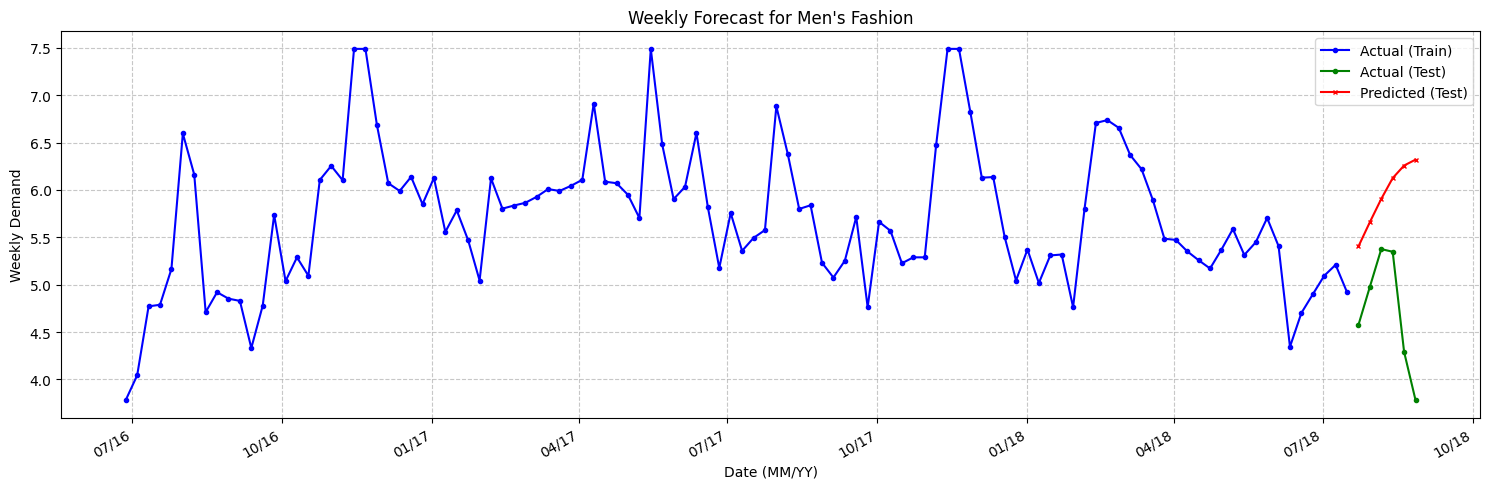

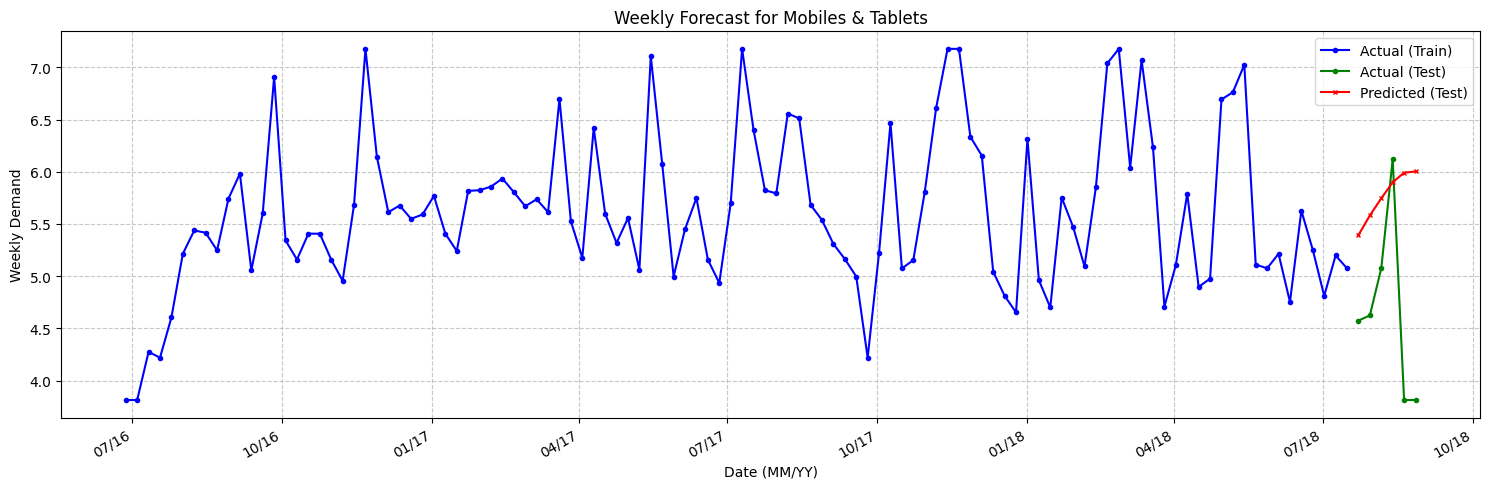

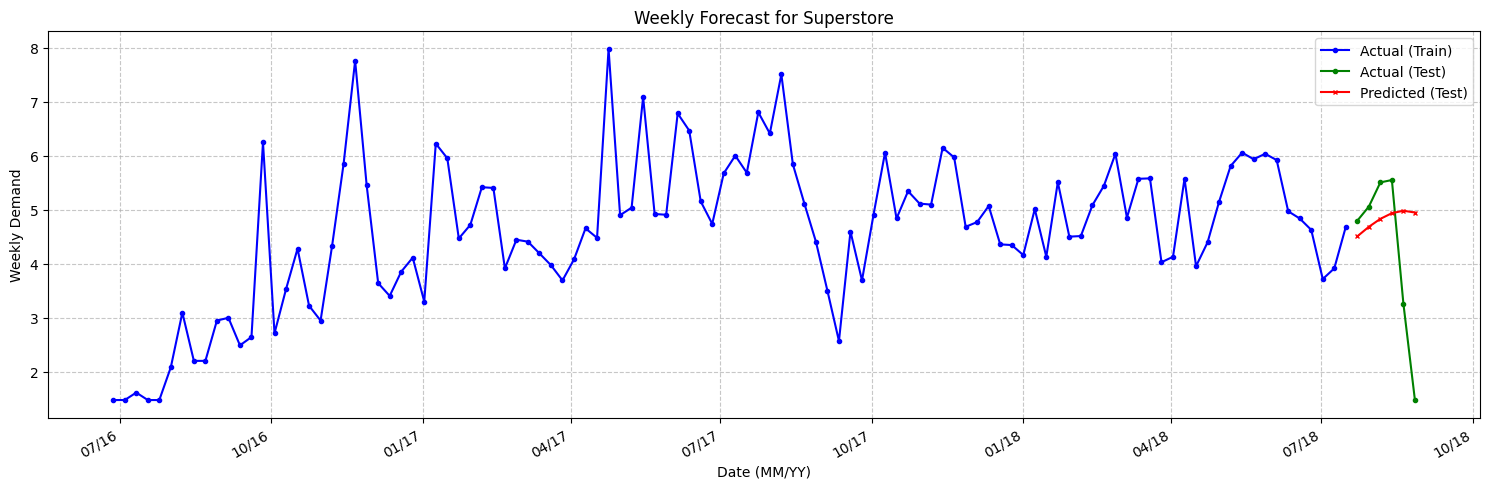

In [21]:
# 9. Plot Results
for i, cat in enumerate(pivot.columns):
    plt.figure(figsize=(15, 5))
    
    # Plot actual training data
    train_dates = train_data.index
    plt.plot(train_dates, train_data[cat], label='Actual (Train)', color='blue', marker='o', markersize=3)
    
    # Plot actual test data
    test_dates = test_data.index
    plt.plot(test_dates, test_data[cat], label='Actual (Test)', color='green', marker='o', markersize=3)
    
    # Plot predicted test data
    plt.plot(test_dates, test_predictions_rescaled[:, i], label='Predicted (Test)', color='red', marker='x', markersize=3)
    
    # Format x-axis dates
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
    plt.gcf().autofmt_xdate()
    
    plt.title(f"Weekly Forecast for {cat}")
    plt.xlabel("Date (MM/YY)")
    plt.ylabel("Weekly Demand")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


In [22]:
# 10. Calculate Metrics

# Create a DataFrame to store metrics
metrics_list = []

for i, cat in enumerate(pivot.columns):
    # Calculate metrics for each category
    mae = mean_absolute_error(test_data[cat], test_predictions_rescaled[:, i])
    rmse = np.sqrt(mean_squared_error(test_data[cat], test_predictions_rescaled[:, i]))
    
    # Calculate MAPE (Mean Absolute Percentage Error)
    # Handle division by zero by using only non-zero actual values
    mask = test_data[cat] != 0
    if np.any(mask):
        mape = np.mean(np.abs((test_data[cat][mask] - test_predictions_rescaled[mask, i]) / test_data[cat][mask])) * 100
    else:
        mape = np.nan
    
    metrics_list.append({
        'Category': cat,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'MAPE': round(mape, 2) if not np.isnan(mape) else 'N/A'
    })

# Create DataFrame from list
metrics_df = pd.DataFrame(metrics_list)

# Display metrics
print("\nError Metrics for Test Set:")
print(metrics_df.to_string(index=False))

# Calculate overall metrics
overall_mae = mean_absolute_error(test_data.values, test_predictions_rescaled)
overall_rmse = np.sqrt(mean_squared_error(test_data.values, test_predictions_rescaled))

# Calculate overall MAPE
# Convert to numpy arrays and flatten
test_data_flat = test_data.values.flatten()
test_pred_flat = test_predictions_rescaled.flatten()

# Calculate MAPE only for non-zero actual values
mask = test_data_flat != 0
if np.any(mask):
    overall_mape = np.mean(np.abs((test_data_flat[mask] - test_pred_flat[mask]) / test_data_flat[mask])) * 100
else:
    overall_mape = np.nan

print("\nOverall Error Metrics for Test Set:")
print(f"Overall MAE: {round(overall_mae, 2)}")
print(f"Overall RMSE: {round(overall_rmse, 2)}")
print(f"Overall MAPE: {round(overall_mape, 2) if not np.isnan(overall_mape) else 'N/A'}%")

# Print interpretation of metrics
print("\nInterpretation:")
print("MAE: Average absolute difference between predicted and actual values")
print("RMSE: Square root of average squared differences (penalizes larger errors more)")
print("MAPE: Average percentage difference between predicted and actual values")


Error Metrics for Test Set:
         Category  MAE  RMSE  MAPE
    Men's Fashion 1.22  1.43 28.20
Mobiles & Tablets 1.17  1.39 28.31
       Superstore 1.19  1.64 54.31

Overall Error Metrics for Test Set:
Overall MAE: 1.19
Overall RMSE: 1.49
Overall MAPE: 36.94%

Interpretation:
MAE: Average absolute difference between predicted and actual values
RMSE: Square root of average squared differences (penalizes larger errors more)
MAPE: Average percentage difference between predicted and actual values
